In [1]:
%cd ..

/home/pablo/long-transformers


In [7]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms

In [3]:
DATA_PATH = "datasets/pathfinder/input/valid.src"

In [6]:
# read one line
with open(DATA_PATH, "r") as f:
    img = f.readline()
pixels = np.array([int(pixel) for pixel in img.split()]).reshape(1, 32, 32)

In [17]:
pixels = []
with open(DATA_PATH, "r") as f:
    for line in f:
        pixels.append([int(pixel) for pixel in line.split()])
pixels = np.array(pixels).reshape(-1, 32, 32)

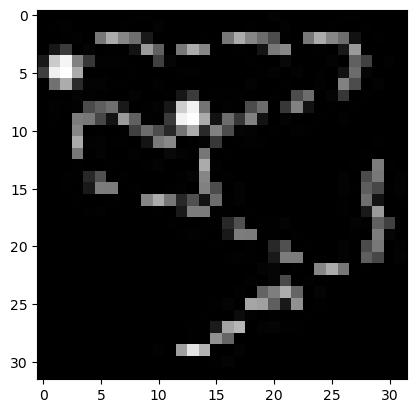

In [21]:
# plot image
plt.imshow(pixels[9], cmap='gray')

In [ ]:
class PathfinderSubdataset(Dataset):
    def __init__(self, data_path, dir_id):
        self.img_dir = os.path.join(data_path, "imgs", str(dir_id))

        # load the metadata
        metadata = pd.read_csv(os.path.join(data_path, "metadata", f"{dir_id}.npy"), sep=" ", header=None)
        self.labels = metadata.iloc[:, 3].values
        self.num_imgs = len(self.labels)

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, f"sample_{idx}.png"))
        label = self.labels[idx]
        return img, label

In [ ]:
def build_dataset(data_path):
    num_dirs = len(glob.glob(os.path.join(DATA_PATH, "metadata", "*.npy")))
    return ConcatDataset([PathfinderSubdataset(data_path, dir_id) for dir_id in range(num_dirs)])

In [ ]:
ds = build_dataset(DATA_PATH)

In [ ]:
tr = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 0.9)),
    # transforms.ToTensor(),
])

tr_tensor = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=5, translate=(0.2, 0.2), scale=(0.6, 0.7), shear=20),
    transforms.ToTensor(),
])

(-0.5, 31.5, 31.5, -0.5)

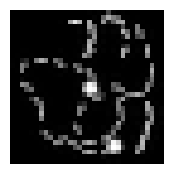

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
image = tr(ds[0][0])

# ax imshow as greyscale
ax.imshow(image, cmap="gray")
ax.axis('off')

In [ ]:
tr_tensor(ds[0][0]).shape

torch.Size([1, 32, 32])

In [ ]:
# create dataloader from torchvision transforms

from torchvision import transforms

class PathfinderDataLoader:
    def __init__(self, data_path, batch_size, num_workers, shuffle=True):
        self.ds = build_dataset(data_path)
        self.dl = DataLoader(
            self.ds,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
        )

    def __iter__(self):
        return iter(self.dl)

    def __len__(self):
        return len(self.dl)

    def __getitem__(self, idx):
        return self.dl[idx]